# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [4]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv")
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [5]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(df) * 0.01)  # 1% of the dataset


#take random data subset
df_subset = df.sample(n=subset_size, random_state=42)


#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)
print(train_df)
print(val_df)

# train_df = ??
# val_df = ??

         Unnamed: 0        Date      Time  Global_active_power  \
1026581     1030580  2008-12-01  09:44:00                1.502   
1815           1815  2006-12-17  23:39:00                0.374   
1291834     1295977  2009-06-03  17:01:00                0.620   
202937       206669  2007-05-09  05:53:00                0.280   
1044824     1048893  2008-12-14  02:57:00                1.372   
...             ...         ...       ...                  ...   
793012       796955  2008-06-22  03:59:00                0.912   
610670       614607  2008-02-16  12:51:00                0.854   
809689       813632  2008-07-03  17:56:00                0.284   
1663194     1674677  2010-02-21  16:41:00                1.742   
576907       580843  2008-01-24  02:07:00                0.392   

         Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
1026581                  0.074   240.17               6.4             0.0   
1815                     0.264   245.50              

In [6]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [12]:
seq_arrays = []
seq_labs = []

In [13]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(seq_length, len(train_df) - ph):
    # Extract the input sequence of GAP readings
    seq = train_df[feat_cols].values[i - seq_length:i]
    seq_arrays.append(seq)
    
    # Extract the output GAP reading at the predictive horizon
    lab = train_df[feat_cols].values[i + ph]
    seq_labs.append(lab)



#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph, len(feat_cols)))

In [10]:
seq_arrays.shape
seq_labs.shape



(16358, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: Generally, assert statements are used to chcek if conditions are true or false.In the above program, assert statements are used to chcek the shape of seq_arrays and seq_labs. Assertions are mianly used to verify if required conditions are met during the execution of the program. Assertion errors are raised if any of the assertion conditions fails to exceute successfully. Assertions are mainly used to debug the code and catch the issues. It helps the developer to make the code work according to the logic without any errors.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [11]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()


#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable pa

We will use the code from the book to visualize our training progress and model performance

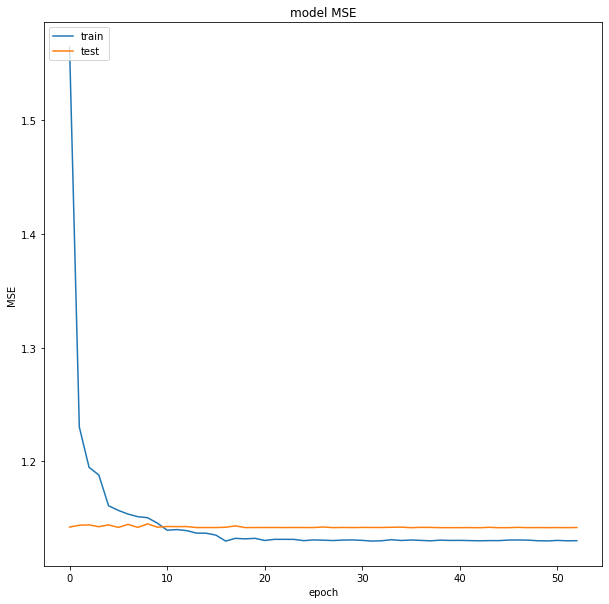

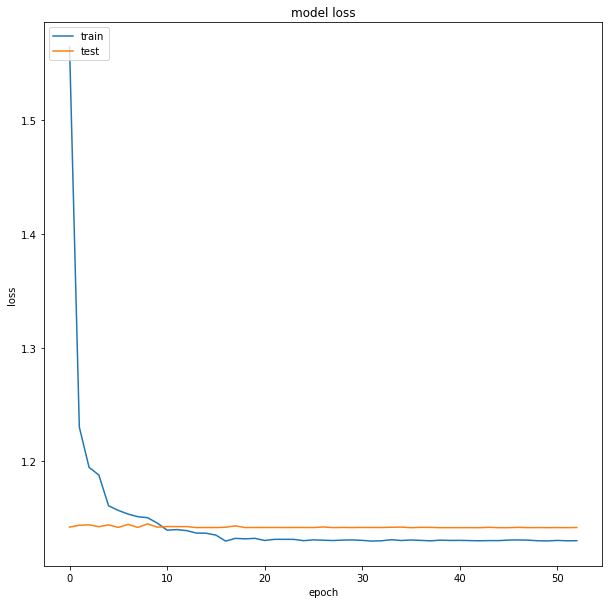

In [14]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function is a utility function provided by Keras that transforms a list of sequences into a padded 2D Numpy array of shape (num_samples, max_seq_len) where num_samples is the number of sequences, and max_seq_len is the maximum length of the sequences in the list. If a sequence is shorter than max_seq_len, it is padded with zeros at the end to make it of length max_seq_len. If a sequence is longer than max_seq_len, it is truncated from the beginning to make it of length max_seq_len.
The "padding" argument determines whether the padding is added at the beginning or at the end of the sequence. For our use case here, it makes more sense to pad sequences at the beginning, since we want to predict future values based on past values, and we want to keep the order of the time series intact. Therefore, we set the "padding" argument to "pre".

In [15]:
val_arrays = []
val_labs = []
#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length + 1, min(len(val_df), 4099 - ph)):
    val_seq = val_df[feat_cols][i - seq_length : i].values.tolist()
    val_arrays.append(val_seq)
    try:
        val_labs.append(val_df['Global_active_power'][i + ph])
    except KeyError:
        print(f"Key Error at index {i}")

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', truncating='pre', value=0.0)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 5s - loss: 1.1000 - mse: 1.0999 - 5s/epoch - 38ms/step

MSE: 1.0998965501785278
127/127 [==============================] - 4s 11ms/step


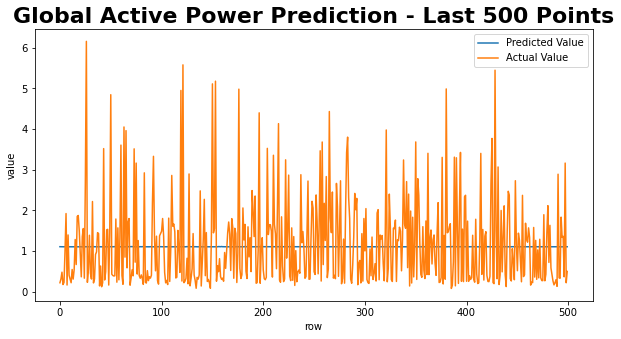

In [16]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The MSE of the model is 1.099. This indicates that the model performed well.Here, while examining the loss curves, I found that training loss is getting decreased steadily , on the other hand validation loss stoped decreasing after reaching certain point and then it started to fluctuate. Based on this analysis, I feel that model turns overfitting to the train data than val data. May be we can try updating the learning rate and also by adding more layers to improve the model's performnace.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: Here, I am going to add more variables to my input sequence. I have added Global_reactive_power, Voltage, Global_intensity, and also adjusted the learning rate to 0.0001.And also I have increased the layers in the LSTM.Model convergence and performance could be improved by changing the optimizer and altering the learning rate.There are only two LSTM layers in the present model. The model can learn more complicated patterns in the data by adding more layers.The model could collect additional information and enhance performance by integrating other variables such as Voltage and Global_intensity.

In [24]:
#Tried adding convolution layer.
# # define path to save model
# from keras.layers import Conv1D
# from keras.layers import Reshape
# model_path = 'LSTM_model2.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# model = Sequential()
# model.add(Reshape((seq_length, nb_features), input_shape=(seq_length * nb_features,)))

# # add convolutional layer
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, nb_features)))

# # add first LSTM layer
# model.add(LSTM(
#          units=64,
#          return_sequences=True))
# model.add(Dropout(0.2)) 

# # add second LSTM layer
# model.add(LSTM(
#           units=32,
#           return_sequences=False))
# model.add(Dropout(0.2))

# # add third LSTM layer
# model.add(LSTM(
#          units=16,
#          return_sequences=False))
# model.add(Dropout(0.2)) 

# # add dense layer
# model.add(Dense(units=nb_out))
# model.add(Activation('linear'))

# # compile the model
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# print(model.summary())

# # fit the network
# history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=512, validation_split=0.05, verbose=2,
#           callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                      keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#           )

# # evaluate the model on the test set
# scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
# print('\nMSE: {}'.format(scores_test[1]))

# # make predictions on the test set
# y_pred_test = model.predict(val_arrays)
# y_true_test = val_labs

# # save the predictions to a CSV file
# test_set = pd.DataFrame(y_pred_test)
# test_set.to_csv('submit_test.csv', index=None)

# # plot the predicted data vs. the actual data
# fig_verify = plt.figure(figsize=(10, 5))
# plt.plot(y_pred_test[-500:], label='Predicted Value')
# plt.plot(y_true_test[-500:], label='Actual Value')
# plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
# plt.ylabel('value')
# plt.xlabel('row')
# plt.legend()
# plt.show()
# fig_verify.savefig("model_regression_verify.png")

# # plot the loss and MSE curves
# fig_acc = plt.figure(figsize=(10, 10))
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
# plt.title('model MSE')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# fig_acc.savefig("LSTM_mse2.png")

# fig_acc = plt.figure(figsize=(10, 10))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# fig_acc.savefig("LSTM_loss2.png")


ValueError: Input 0 of layer "lstm_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

In [31]:
seq_arrays = []
seq_labs = []
# play with your ideas for optimization here
seq_length = 15
ph = 2

feat_cols = ['Global_active_power', 'Global_intensity', 'Voltage']
# #create list of sequence length GAP readings

for i in range(seq_length, len(train_df) - ph):
    # Extract the sequence of GAP measurements as input
    seq = train_df[feat_cols].values[i - seq_length:i]
    # Extract the GAP measurement at the predictive horizon as output
    lab = train_df[feat_cols].values[i + ph]
    
    # Append the input sequence and output label to the lists
    seq_arrays.append(seq)
    seq_labs.append(lab)


#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

print(seq_arrays.shape)
print(seq_labs.shape)

# define path to save model
model_path = 'LSTM_model2.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length,nb_features),
         units=10, 
         return_sequences=True))
model.add(Dropout(0.2)) 

model.add(LSTM(8, input_shape=(seq_length, nb_features), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=5,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.05) #changing learning rate
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

(16376, 15, 3)
(16376, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 15, 10)            560       
                                                                 
 dropout_12 (Dropout)        (None, 15, 10)            0         
                                                                 
 lstm_15 (LSTM)              (None, 15, 8)             608       
                                                                 
 dropout_13 (Dropout)        (None, 15, 8)             0         
                                                                 
 lstm_16 (LSTM)              (None, 5)                 280       
                                                                 
 dropout_14 (Dropout)        (None, 5)                 0         
                                                                 
 dense_3 (Dense)            

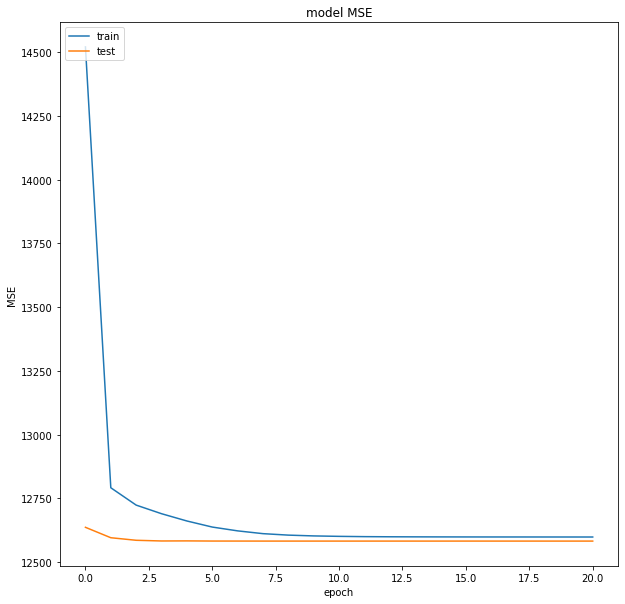

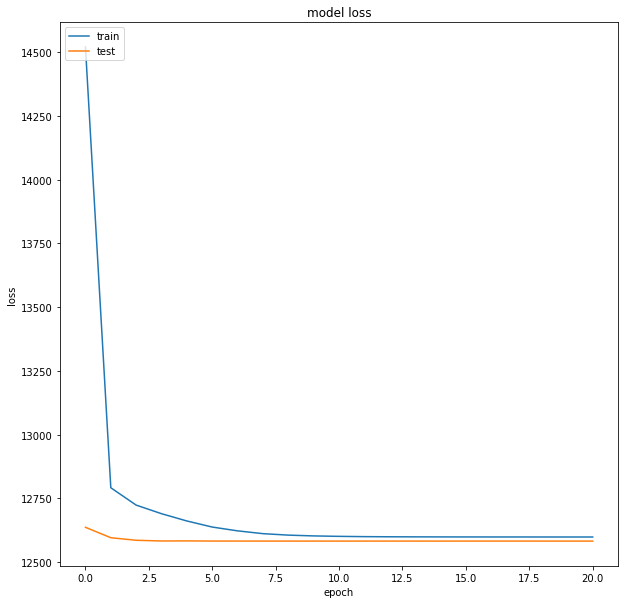

In [32]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [25]:
#Trying to add more variables and modifying the learning_rate.
df = pd.read_csv("household_power_clean.csv")
df.head() 

# create your training and validation sets here

# assign size for data subset
subset_size = int(len(df) * 0.01)  # 1% of the dataset

# take random data subset
df_subset = df.sample(n=subset_size, random_state=42)

# split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)
print(train_df)

         Unnamed: 0        Date      Time  Global_active_power  \
1026581     1030580  2008-12-01  09:44:00                1.502   
1815           1815  2006-12-17  23:39:00                0.374   
1291834     1295977  2009-06-03  17:01:00                0.620   
202937       206669  2007-05-09  05:53:00                0.280   
1044824     1048893  2008-12-14  02:57:00                1.372   
...             ...         ...       ...                  ...   
793012       796955  2008-06-22  03:59:00                0.912   
610670       614607  2008-02-16  12:51:00                0.854   
809689       813632  2008-07-03  17:56:00                0.284   
1663194     1674677  2010-02-21  16:41:00                1.742   
576907       580843  2008-01-24  02:07:00                0.392   

         Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
1026581                  0.074   240.17               6.4             0.0   
1815                     0.264   245.50              

In [26]:
seq_length = 30
ph = 5

# define the features to be included in the input sequence
feat_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']

# create list of sequence length readings for each feature
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(train_df) - ph):
    # Extract the input sequence of readings for each feature
    seq = train_df[feat_cols].values[i - seq_length:i]
    seq_arrays.append(seq)
    
    # Extract the output reading at the predictive horizon
    lab = train_df[feat_cols].values[i + ph]
    seq_labs.append(lab)
    
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

assert(seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph, len(feat_cols)))

In [27]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
model_path = 'LSTM_model2.h5'

# build the network
nb_features = len(feat_cols)
nb_out = len(feat_cols)

model = Sequential()

# add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=128, 
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=64,
          return_sequences=True))
model.add(Dropout(0.2))

# add third LSTM layer
model.add(LSTM(
          units=32,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=512, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 30, 128)           68096     
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 30, 64)            49408     
                                                                 
 dropout_10 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**
A: Model convergence and performance could be improved by changing the optimizer and altering the learning rate.There are only two LSTM layers in the present model. The model can learn more complicated patterns in the data by adding more layers.The model could collect additional information and enhance performance by integrating other variables such as Voltage and Global_intensity.I would like to try adding convolution layer next as I am very interested to look into it.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: I would choose a simpler model with reduced processing requirements, such as the linear regression model, to utilize in an IoT system that predicts GAP for a single household with a 5-minute forecast horizon. This is because the 5-minute forecast horizon is so small, and we don't need the LSTM models' complexity and computing requirements to produce accurate predictions. Moreover, using a simpler model would make it easier to integrate into an IoT system and lower the possibility of computational errors or delays. Overall, the LSTM models we created for this assignment performed better on validation data than the linear regression model. The LSTM models were able to capture the nonlinear interactions in the data and forecast the GAP better.